# Data Exploration

In [2]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [3]:
from pyspark.sql.functions import col, countDistinct

def relate_bar_chart(df, groupCol):
    """ Give a dataframe, and a column to group by, create a bar chart of all 
        variables that don't change as the group by changes
    """

    exCols = []

    # Count distinct values of rows where assignment_start_date is null
    dfCounts = df.groupBy(groupCol).agg(*(countDistinct(col(c)).alias("n_" + c) for c in df.columns))

    # Filter fields to those with count of 1
    for row in dfCounts.collect():
      for c in dfCounts.columns:
        if (row[c] != 1):
          exCols.append(c)


    exCols  = list(set(exCols)) # Get unique list
    exCols.append("n_" + groupCol) # Exclude the column we group by
    allCols = dfCounts.columns
    inCols  = [col for col in allCols if col not in exCols] # Return cols not in exCols


    dfCounts.select(*inCols, groupCol).toPandas().plot.bar(x=groupCol, figsize=(7,7))


In [4]:
# Load Assessment Items Data
from pyspark import SparkFiles

url = 'https://github.com/dlhinkley/c772-capstone-project/raw/master/data/assessment_items.csv'

spark.sparkContext.addFile(url)

file = "file://" + SparkFiles.get("assessment_items.csv")

dfRaw = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(file)

In [5]:
from pyspark.sql.functions import countDistinct, count, when, col, min, max

dfRaw.agg(
  count( when(col("is_deleted") == True, "is_deleted")).alias("num_deleted")
).show(1, False)

+-----------+
num_deleted|
+-----------+
0 |
+-----------+

Zero observations deleted.  This variable can be deleted

In [7]:
dfRaw = dfRaw.drop("is_deleted")

In [8]:
from pyspark import SparkFiles

url = 'https://github.com/dlhinkley/c772-capstone-project/raw/master/data/descriptions.csv'

spark.sparkContext.addFile(url)

file = "file://" + SparkFiles.get("descriptions.csv")

dfDesc = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(file)

In [9]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
dfPanda = dfDesc.toPandas()
dfPanda

,field,type,description
0,assessment_id,Categorical Identifier,ID of an Assessment.
1,assessment_instance_attempt_id,Categorical Identifier,ID of a learner's attempt of an assessment.
2,assessment_instance_id,Categorical Identifier,ID of a section's instance of an assessment.
3,assessment_item_response_id,Categorical Identifier,ID of a learners response to an assessment item.
4,assigned_item_status,Categorical Nominal,"Code indicating the status of the assessment item. Example: assigned, responded, offline_scorred, etc."
5,assignment_attempt_number,Numeric Continuous,The nth time a certain learner attempted the assessement.
6,assignment_due_date,Categorical Interval,The date and time the assignment is due.
7,assignment_final_submission_date,Categorical Interval,The date and time the assignment was submitted for scoring.
8,assignment_late_submission,Categorical Binary,True if the assignment was submitted late.
9,assignment_max_attempts,Numeric Continuous,The number of times a learner can attempt the assessment.


In [10]:
from pyspark.sql.functions import col

# Save field names
identifierFieldRows = dfDesc.filter("type = 'Categorical Identifier'")
identifierFields = [row['field'] for row in identifierFieldRows.select("field").collect()]
identifierFieldRows.select(col("field").alias('Categorical Identifier')).show(20,False)

nominalFieldRows    = dfDesc.filter("type = 'Categorical Nominal'")
nominalFields = [row['field'] for row in nominalFieldRows.select("field").collect()]
nominalFieldRows.select(col("field").alias('Categorical Nominal')).show(20,False)

continousFieldRows  = dfDesc.filter("type = 'Numeric Continuous'")
continousFields = [row['field'] for row in continousFieldRows.select("field").collect()]
continousFieldRows.select(col("field").alias('Numeric Continuous')).show(20,False)

intervalFieldRows   = dfDesc.filter("type = 'Categorical Interval'")
intervalFields = [row['field'] for row in intervalFieldRows.select("field").collect()]
intervalFieldRows.select(col("field").alias('Categorical Interval')).show(20,False)

binaryFieldRows     = dfDesc.filter("type = 'Categorical Binary'")
binaryFields = [row['field'] for row in binaryFieldRows.select("field").collect()]
binaryFieldRows.select(col("field").alias('Categorical Binary')).show(20,False)


+--------------------------------+
Categorical Identifier |
+--------------------------------+
assessment_id |
assessment_instance_attempt_id |
assessment_instance_id |
assessment_item_response_id |
learner_assigned_item_attempt_id|
learner_assignment_attempt_id |
learner_id |
org_id |
section_id |
+--------------------------------+

+------------------------+
Categorical Nominal |
+------------------------+
assigned_item_status |
ced_assignment_type_code|
item_type_code_name |
learner_attempt_status |
response_correctness |
scoring_type_code |
+------------------------+

+---------------------------------+
Numeric Continuous |
+---------------------------------+
assignment_attempt_number |
assignment_max_attempts |
final_score_unweighted |
number_of_distinct_instance_items|
number_of_learners |
points_possible_unweighted |
+---------------------------------+

+--------------------------------+
Categorical Interval |
+--------------------------------+
assignment_due_date |
assignment_final_submission_date|
assignment_start_date |
max_student_stop_datetime |
min_student_start_datetime |
scored_datetime |
student_start_datetime |
student_stop_datetime |
was_fully_scored_datetime |
was_in_progress_datetime |
was_submitted_datetime_actual |
+--------------------------------+

+--------------------------+
Categorical Binary |
+--------------------------+
assignment_late_submission|
is_affecting_grade |
is_deleted |
is_force_scored |
is_manual_scoring_required|
item_is_offline_scored |
+--------------------------+

In [11]:
# Set empty dates to null
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

for f in intervalFields:
  dfRaw = dfRaw.withColumn(f, col(f).cast(TimestampType() ) )


In [12]:
# Schema
dfRaw.printSchema()

root
-- ced_assignment_type_code: string (nullable = true)
-- is_affecting_grade: boolean (nullable = true)
-- number_of_learners: integer (nullable = true)
-- number_of_distinct_instance_items: integer (nullable = true)
-- assignment_max_attempts: integer (nullable = true)
-- assignment_late_submission: boolean (nullable = true)
-- assignment_final_submission_date: timestamp (nullable = true)
-- assignment_start_date: timestamp (nullable = true)
-- assignment_due_date: timestamp (nullable = true)
-- min_student_start_datetime: timestamp (nullable = true)
-- max_student_stop_datetime: timestamp (nullable = true)
-- assignment_attempt_number: integer (nullable = true)
-- was_fully_scored_datetime: timestamp (nullable = true)
-- was_submitted_datetime_actual: timestamp (nullable = true)
-- was_in_progress_datetime: timestamp (nullable = true)
-- is_force_scored: boolean (nullable = true)
-- is_manual_scoring_required: boolean (nullable = true)
-- student_start_datetime: timestamp (nullable = true)
-- student_stop_datetime: timestamp (nullable = true)
-- item_is_offline_scored: boolean (nullable = true)
-- learner_attempt_status: string (nullable = true)
-- points_possible_unweighted: double (nullable = true)
-- final_score_unweighted: integer (nullable = true)
-- scored_datetime: timestamp (nullable = true)
-- item_type_code_name: string (nullable = true)
-- scoring_type_code: string (nullable = true)
-- response_correctness: string (nullable = true)
-- assigned_item_status: string (nullable = true)
-- org_id: integer (nullable = true)
-- section_id: integer (nullable = true)
-- assessment_id: integer (nullable = true)
-- assessment_instance_id: integer (nullable = true)
-- learner_assignment_attempt_id: integer (nullable = true)
-- assessment_instance_attempt_id: integer (nullable = true)
-- learner_id: integer (nullable = true)
-- learner_assigned_item_attempt_id: integer (nullable = true)
-- assessment_item_response_id: integer (nullable = true)

In [13]:
# Save as database view
dfRaw.createOrReplaceTempView("raw_data")


In [14]:
from pyspark.sql.functions import when, count, col, countDistinct

for f in identifierFields:
  print(f)
  dfRaw.agg(
    countDistinct(f).alias("unique"), 
    count(when(col(f).isNull(), f)).alias("null")
  ).show()


assessment_id
+------+----+
unique|null|
+------+----+
 454| 0|
+------+----+

assessment_instance_attempt_id
+------+-----+
unique| null|
+------+-----+
 11780|57745|
+------+-----+

assessment_instance_id
+------+----+
unique|null|
+------+----+
 824| 0|
+------+----+

assessment_item_response_id
+------+-----+
unique| null|
+------+-----+
 77746|70683|
+------+-----+

learner_assigned_item_attempt_id
+------+----+
unique|null|
+------+----+
147650| 0|
+------+----+

learner_assignment_attempt_id
+------+----+
unique|null|
+------+----+
 19013| 0|
+------+----+

learner_id
+------+----+
unique|null|
+------+----+
 1223| 0|
+------+----+

org_id
+------+----+
unique|null|
+------+----+
 3| 0|
+------+----+

section_id
+------+----+
unique|null|
+------+----+
 50| 0|
+------+----+

In [15]:
# Categorical / Nominal Values
for f in nominalFields:
  dfRaw.groupBy(f).count().orderBy("count", ascending=False).show(50, False)
  

+--------------------+-----+
assigned_item_status|count|
+--------------------+-----+
scored |76284|
assigned |57745|
offline_scored |12476|
responded |2840 |
delivered |462 |
+--------------------+-----+

+------------------------+------+
ced_assignment_type_code|count |
+------------------------+------+
assessment |137501|
practice |9800 |
game |1555 |
clo |940 |
rubric |11 |
+------------------------+------+

+----------------------+-----+
item_type_code_name |count|
+----------------------+-----+
null |57745|
multipleChoice |35827|
fillInTheBlank |15628|
equationEntry |10964|
trueFalse |5506 |
cloze |4244 |
essay |3351 |
multipleSelect |3159 |
graphing |2415 |
choiceMatrix |1811 |
MultipleChoiceResponse|1550 |
shortAnswer |1526 |
selectText |1520 |
bucketing |1433 |
matching |1292 |
sortable |838 |
numberLine |573 |
aheAlgo |230 |
imageLabel |112 |
fileUpload |67 |
RubricResponse |11 |
FillinBlankResponse |5 |
+----------------------+-----+

+----------------------+-----+
learner_attempt_status|count|
+----------------------+-----+
fully scored |80548|
assigned |42010|
awaiting outcome |14740|
in progress |12509|
+----------------------+-----+

+--------------------+-----+
response_correctness|count|
+--------------------+-----+
null |61047|
correct |49463|
incorrect |35729|
partially_correct |2002 |
[unassigned] |1566 |
+--------------------+-----+

+-----------------+-----+
scoring_type_code|count|
+-----------------+-----+
automatic |84853|
[unassigned] |62613|
manual |2113 |
external |228 |
+-----------------+-----+

- learner_attempt_status of "fully scored"
  - The tests with a final score
  - We will be analyzing only these scores
- item_type_code_name: 57,745 null values
- response_correctness: 61,047 null values

#### Null Values
- response_correctness
  - Investigate further
  - Could be null because the question wasn't answered or a different method of scoring the question
- item_type_code_name
  - Investigate further
  - Could be related to unstarted or unanswered questions

#### Large number of categorical values
- item_type_code_name
  - Need to transform by reclassifying to reduce number of categories

In [18]:
# Numerical / Continuous Variables
desc = dfRaw.describe()
for f in continousFields:
  desc.select("summary", f).show(5,False)


+-------+-------------------------+
summary|assignment_attempt_number|
+-------+-------------------------+
count |149807 |
mean |0.9895465498941972 |
stddev |0.10170665925672463 |
min |0 |
max |1 |
+-------+-------------------------+

+-------+-----------------------+
summary|assignment_max_attempts|
+-------+-----------------------+
count |149807 |
mean |0.9895465498941972 |
stddev |0.10170665925672463 |
min |0 |
max |1 |
+-------+-----------------------+

+-------+----------------------+
summary|final_score_unweighted|
+-------+----------------------+
count |149807 |
mean |7.314998631572624 |
stddev |12.845308068399365 |
min |0 |
max |60 |
+-------+----------------------+

+-------+---------------------------------+
summary|number_of_distinct_instance_items|
+-------+---------------------------------+
count |149807 |
mean |15.645523907427556 |
stddev |12.59598111877567 |
min |1 |
max |99 |
+-------+---------------------------------+

+-------+------------------+
summary|number_of_learners|
+-------+------------------+
count |149807 |
mean |29.632587262277465|
stddev |8.633190773672018 |
min |1 |
max |47 |
+-------+------------------+

+-------+--------------------------+
summary|points_possible_unweighted|
+-------+--------------------------+
count |149807 |
mean |19.593267737822668 |
stddev |16.08475797688487 |
min |1.0 |
max |156.0 |
+-------+--------------------------+

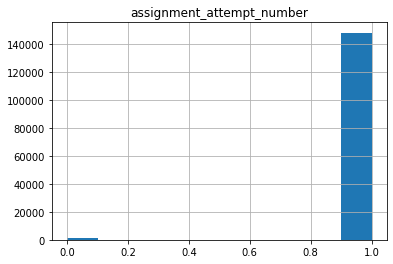

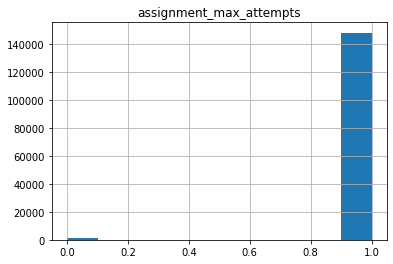

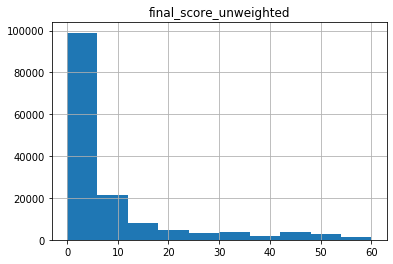

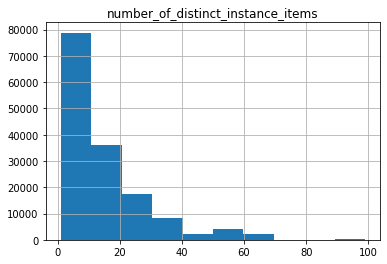

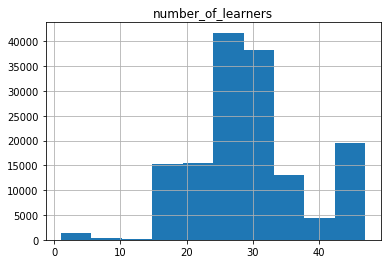

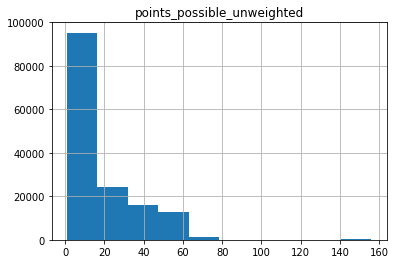

In [19]:
for f in continousFields:
  print(f)
  dfRaw.select(f).toPandas().hist()

Normal Distribution
- number_of_learners

Right Skewed
- final_score_unweighted
- number_of_distinct_instance_items
- points_possible_unweighted

Two Values (0/1)
- assignment_max_attempts
- assignment_attempt_number
- Appears binary but the variable name indicates it could have any values. The data only contains 1 and 0

In [21]:
from pyspark.sql.functions import count, when, col

for c in continousFields:
  print(c)
  dfRaw.agg(
    count(when(col(c).isNull(), c)).alias("null"),
    count(when(col(c) == 0, c)).alias("zero")
  ).show()

assignment_attempt_number
+----+----+
null|zero|
+----+----+
 0|1566|
+----+----+

assignment_max_attempts
+----+----+
null|zero|
+----+----+
 0|1566|
+----+----+

final_score_unweighted
+----+-----+
null| zero|
+----+-----+
 0|83679|
+----+-----+

number_of_distinct_instance_items
+----+----+
null|zero|
+----+----+
 0| 0|
+----+----+

number_of_learners
+----+----+
null|zero|
+----+----+
 0| 0|
+----+----+

points_possible_unweighted
+----+----+
null|zero|
+----+----+
 0| 0|
+----+----+

- possibile correlation between assignment_attempt_number and assignment_max_attempts
  - both have 1566 zero values
  - Needs further investigation
- final_score_unweighted has 83,670 zero values

In [23]:
from pyspark.sql.functions import countDistinct, count, when, col, min, max

for f in intervalFields:
  print (f)
  dfRaw.agg(
    countDistinct(f).alias("unique"), 
    count(when(col(f).isNull(), f)).alias("null"),
    min(f).alias("min"),
    max(f).alias("max")
 ).show(1, False)


assignment_due_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
220 |0 |2019-08-23 04:59:00|2999-01-01 00:00:00|
+------+----+-------------------+-------------------+

assignment_final_submission_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
230 |0 |2019-08-23 04:59:00|2999-01-01 00:00:00|
+------+----+-------------------+-------------------+

assignment_start_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
240 |0 |1900-01-01 00:00:00|2020-05-22 05:00:00|
+------+----+-------------------+-------------------+

max_student_stop_datetime
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
639 |0 |2019-08-22 04:06:27.518|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

min_student_start_datetime
+------+----+-------------------+-----------------------+
unique|null|min |max |
+------+----+-------------------+-----------------------+
773 |0 |1900-01-01 00:00:00|2020-05-22 15:33:39.154|
+------+----+-------------------+-----------------------+

scored_datetime
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
7286 |0 |2019-08-22 02:37:58|2999-01-01 00:00:00|
+------+----+-------------------+-------------------+

student_start_datetime
+------+----+-------------------+-----------------------+
unique|null|min |max |
+------+----+-------------------+-----------------------+
10831 |0 |1900-01-01 00:00:00|2020-05-26 04:59:17.367|
+------+----+-------------------+-----------------------+

student_stop_datetime
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
8850 |0 |2019-08-21 23:44:42.693|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

was_fully_scored_datetime
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
8657 |0 |2019-08-22 02:37:59.012|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

was_in_progress_datetime
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
10731 |0 |2019-08-21 23:33:10.917|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

was_submitted_datetime_actual
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
8169 |0 |2019-08-21 23:44:42.693|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

Default Date Values
- All variables have some dates have default values '2999-01-01 00:00:00' as max and '1900-01-01 00:00:00' as min
- These are substitutes for no value and will need to be replaced nulls
- Further investigation is needed as what the nulls mean

In [25]:
from pyspark.sql.functions import countDistinct, count, when, col, min, max

# Categorical / Interval Variables
defaults = ["2999-01-01 00:00:00","1900-01-01 00:00:00"]

for f in intervalFields:
  print (f)
  dfRaw.agg(
    countDistinct(f).alias("unique"), 
    count( when(col(f).isNull(), f)).alias("null"),
    min( when(col(f).isin(defaults) == False, col(f) )).alias("min"),
    max( when(col(f).isin(defaults) == False, col(f) )).alias("max")
 ).show(1, False)

assignment_due_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
220 |0 |2019-08-23 04:59:00|2020-05-26 04:59:00|
+------+----+-------------------+-------------------+

assignment_final_submission_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
230 |0 |2019-08-23 04:59:00|2020-06-05 04:59:00|
+------+----+-------------------+-------------------+

assignment_start_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
240 |0 |2019-08-21 05:00:00|2020-05-22 05:00:00|
+------+----+-------------------+-------------------+

max_student_stop_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
639 |0 |2019-08-22 04:06:27.518|2020-05-26 06:48:38.546|
+------+----+-----------------------+-----------------------+

min_student_start_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
773 |0 |2019-08-21 23:33:10.917|2020-05-22 15:33:39.154|
+------+----+-----------------------+-----------------------+

scored_datetime
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
7286 |0 |2019-08-22 02:37:58|2020-05-26 04:59:53|
+------+----+-------------------+-------------------+

student_start_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
10831 |0 |2019-08-21 23:33:10.917|2020-05-26 04:59:17.367|
+------+----+-----------------------+-----------------------+

student_stop_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
8850 |0 |2019-08-21 23:44:42.693|2020-05-26 06:48:38.546|
+------+----+-----------------------+-----------------------+

was_fully_scored_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
8657 |0 |2019-08-22 02:37:59.012|2020-05-26 04:59:53.903|
+------+----+-----------------------+-----------------------+

was_in_progress_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
10731 |0 |2019-08-21 23:33:10.917|2020-05-26 03:30:53.599|
+------+----+-----------------------+-----------------------+

was_submitted_datetime_actual
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
8169 |0 |2019-08-21 23:44:42.693|2020-05-26 06:48:38.546|
+------+----+-----------------------+-----------------------+

Dates fall in range of a school year of 8/2019 to 5/2020

# Data Cleaning

In [28]:
dfClean = dfRaw.filter("learner_attempt_status = 'fully scored'")

### Convert Default / Empty Dates to NULL

In [30]:
from pyspark.sql.functions import count, col
# Count Default / Empty Dates

for f in intervalFields:
  row = dfClean.filter( (col(f) == '2999-01-01 00:00:00') | (col(f) == '1900-01-01 00:00:00') ).select(count(f).alias("null")).collect()
  found = row[0][0]
  if (found > 0):
    print (f,"=", found)

assignment_due_date = 1566
assignment_final_submission_date = 1566
assignment_start_date = 1566
scored_datetime = 3422
student_start_datetime = 749
student_stop_datetime = 749
was_fully_scored_datetime = 750
was_in_progress_datetime = 9965
was_submitted_datetime_actual = 18469

In [31]:
# Set empty dates to null
from pyspark.sql.functions import when, col

for f in intervalFields:
  dfClean = dfClean.withColumn(f, when((col(f) == '2999-01-01 00:00:00') | (col(f) == '1900-01-01 00:00:00'), None ).otherwise( col(f) ) )


In [32]:
# Count Default / Empty Dates
exists = 0
for f in intervalFields:
  row = dfClean.filter( (col(f) == '2999-01-01 00:00:00') | (col(f) == '1900-01-01 00:00:00') ).select(count(f).alias("null")).collect()
  found = row[0][0]
  if (found > 0):
    exists += 1
    print (f,"=", found)
    
if (exists == 0):
  print ("None Found")
else:
  print ("Found", exists)

None Found

##### All default dates converted

# Investigations

### Does learner_attempt_status of "fully scored" relate to other variables

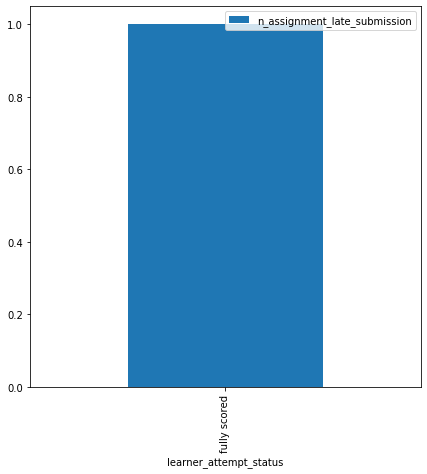

In [36]:
relate_bar_chart(dfClean, "learner_attempt_status")

- The only column that is always the same value when "fully scored" is assignment_late_submission
- What is that value?

In [38]:
dfClean.where(col("learner_attempt_status") == "fully scored").select('assignment_late_submission').distinct().show()

+--------------------------+
assignment_late_submission|
+--------------------------+
 false|
+--------------------------+

- The value is false
- When learner_attempt_status is "fully scored", the assigment is never submitted late

### Why Are Empty Dates Empty

In [41]:
# Save as database view
dfClean.createOrReplaceTempView("clean_data")

In [42]:
from pyspark.sql.functions import count, col
# Count Default / Empty Dates

for f in intervalFields:
  count = dfClean.filter(col(f).isNull() == True).count()
  print (f,"=", count)

assignment_due_date = 1566
assignment_final_submission_date = 1566
assignment_start_date = 1566
max_student_stop_datetime = 0
min_student_start_datetime = 0
scored_datetime = 3422
student_start_datetime = 749
student_stop_datetime = 749
was_fully_scored_datetime = 750
was_in_progress_datetime = 9965
was_submitted_datetime_actual = 18469

Are the following related?
- assignment_due_date, assignment_final_submission_date and assignment_start_date have 1566 empty dates
- assignment_attempt_number and assignment_max_attempts have 1566 records with the value 0
- there are 1566 records with the response_correctness "[unassigned]"

In [44]:
%sql
-- Count the records
SELECT count(*)
FROM clean_data
WHERE assignment_due_date IS NULL 
  AND assignment_final_submission_date IS NULL
  AND assignment_start_date IS NULL
  AND assignment_attempt_number = 0 
  AND assignment_max_attempts = 0
  AND response_correctness = '[unassigned]';


count(1)
1566


Yes they are releated
- The same records all have 1566 empty

Does the same 1566 also include these
- student_start_datetime = 749
- student_stop_datetime = 749

In [47]:
%sql
-- Count the records
SELECT count(*)
FROM clean_data
WHERE student_start_datetime IS NULL
  AND student_stop_datetime IS NULL
  AND assignment_due_date IS NULL 
  AND assignment_final_submission_date IS NULL
  AND assignment_start_date IS NULL
  AND assignment_attempt_number = 0 
  AND assignment_max_attempts = 0
  AND response_correctness = '[unassigned]';

count(1)
0


They do not

Does the same 1566 also include these
- was_fully_scored_datetime = 750

In [50]:
%sql
-- Count the records
SELECT count(*)
FROM clean_data
WHERE was_fully_scored_datetime IS NULL
  AND assignment_due_date IS NULL 
  AND assignment_final_submission_date IS NULL
  AND assignment_start_date IS NULL
  AND assignment_attempt_number = 0 
  AND assignment_max_attempts = 0
  AND response_correctness = '[unassigned]';

count(1)
0


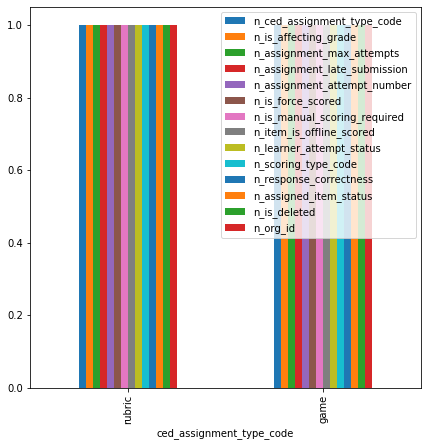

In [51]:
df = dfClean.where(col("assignment_start_date").isNull())
relate_bar_chart(df, "ced_assignment_type_code")

They do not

### Reclassify categories in item_type_code_name

In [54]:
# Before Categories
dfClean.select("item_type_code_name").distinct().orderBy("item_type_code_name").show(50, False)


+----------------------+
item_type_code_name |
+----------------------+
null |
FillinBlankResponse |
MultipleChoiceResponse|
RubricResponse |
aheAlgo |
bucketing |
choiceMatrix |
cloze |
equationEntry |
essay |
fileUpload |
fillInTheBlank |
graphing |
imageLabel |
matching |
multipleChoice |
multipleSelect |
numberLine |
selectText |
shortAnswer |
sortable |
trueFalse |
+----------------------+

Combine Suffix Levels
- The levels with the suffix Response (ex: FillinBlankResponse) is the same type of question as level without the suffix (ex: fillInTheBlank)

In [56]:
# Combine fillInTheBlank and FillinBlankResponse 
dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name") == "FillinBlankResponse", "fillInTheBlank" ).otherwise(col("item_type_code_name")) )

# Combine multipleChoice and MultipleChoiceResponse 
dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name") == "MultipleChoiceResponse", "multipleChoice" ).otherwise(col("item_type_code_name")) )


In [57]:
from pyspark.sql.functions import col, round

tot = dfClean.filter(col("item_type_code_name").isNull() == False).count()

freqTable = dfClean.groupBy("item_type_code_name") \
               .count() \
               .withColumnRenamed('count', 'cnt_per_group') \
               .withColumn('perc_of_count_total', ( col('cnt_per_group') / tot) * 100 ) \
               .orderBy("cnt_per_group", ascending=False)

freqTable.show(50, False)

+-------------------+-------------+--------------------+
item_type_code_name|cnt_per_group|perc_of_count_total |
+-------------------+-------------+--------------------+
multipleChoice |34001 |43.99487604161275 |
fillInTheBlank |12077 |15.626779152217793 |
equationEntry |9516 |12.313027276020911 |
trueFalse |4963 |6.421769059572485 |
cloze |3576 |4.627089695150355 |
null |3264 |4.223383882821801 |
multipleSelect |2691 |3.481962631333782 |
graphing |2415 |3.1248382588892913 |
choiceMatrix |1336 |1.7286889912530408 |
matching |1164 |1.5061332229180686 |
bucketing |1051 |1.3599192588375342 |
selectText |1025 |1.3262771078101547 |
essay |1000 |1.2939288856684437 |
shortAnswer |983 |1.27193209461208 |
sortable |644 |0.8332902023704778 |
numberLine |455 |0.5887376429791419 |
aheAlgo |219 |0.2833704259613891 |
imageLabel |108 |0.13974431965219192 |
fileUpload |49 |0.06340251539775374 |
RubricResponse |11 |0.014233217742352882|
+-------------------+-------------+--------------------+

We only want four levels, so convert everything below 6% to other

In [59]:
otherRows    = freqTable.filter("perc_of_count_total < 6")
otherLevels  = [row['item_type_code_name'] for row in otherRows.select("item_type_code_name").collect()]

dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name").isin(otherLevels) | col("item_type_code_name").isNull() , "Other" ).otherwise(col("item_type_code_name")) )

# Display new values
dfClean.groupBy("item_type_code_name").count().orderBy("count", ascending=False).show(50, False)


+-------------------+-----+
item_type_code_name|count|
+-------------------+-----+
multipleChoice |34001|
Other |19991|
fillInTheBlank |12077|
equationEntry |9516 |
trueFalse |4963 |
+-------------------+-----+

In [60]:
dfClean.createOrReplaceTempView("clean_data")

# Data Aggregation

In [62]:
%sql
DROP TABLE IF EXISTS answers_by_attempt;
CREATE TABLE answers_by_attempt AS (
    SELECT a.learner_assignment_attempt_id,
           count(a.assessment_item_response_id)   num_questions_answered
    FROM (
        SELECT DISTINCT learner_assignment_attempt_id, learner_assigned_item_attempt_id, assessment_item_response_id
        FROM clean_data
        WHERE learner_attempt_status = 'fully scored'
    ) a
    GROUP BY a.learner_assignment_attempt_id
)

In [63]:
spark.sql("SELECT * FROM answers_by_attempt").printSchema()


root
-- learner_assignment_attempt_id: integer (nullable = true)
-- num_questions_answered: long (nullable = true)

In [64]:
%sql
DROP TABLE IF EXISTS scores;
CREATE TABLE scores AS (
   SELECT DISTINCT (cl.learner_assignment_attempt_id)  AS attempt_id,
                         cl.assessment_id,
                         cl.learner_id,
                         cl.section_id,
                         cl.org_id,
                         cl.final_score_unweighted AS num_final_score,
                         cl.points_possible_unweighted AS num_possible_score,
                         DATE(was_fully_scored_datetime) AS scored_date,
                         cl.number_of_distinct_instance_items AS num_questions, -- number of questions
                         aba.num_questions_answered
         FROM clean_data cl
         LEFT JOIN answers_by_attempt aba ON cl.learner_assignment_attempt_id = aba.learner_assignment_attempt_id
         WHERE learner_attempt_status = 'fully scored'
);

In [65]:
spark.sql("SELECT * FROM scores").printSchema()


root
-- attempt_id: integer (nullable = true)
-- assessment_id: integer (nullable = true)
-- learner_id: integer (nullable = true)
-- section_id: integer (nullable = true)
-- org_id: integer (nullable = true)
-- num_final_score: integer (nullable = true)
-- num_possible_score: double (nullable = true)
-- scored_date: date (nullable = true)
-- num_questions: integer (nullable = true)
-- num_questions_answered: long (nullable = true)

In [66]:
%sql
DROP TABLE IF EXISTS learners;
CREATE TABLE learners AS (
         SELECT learner_id,
                section_id,
                org_id,
                MIN( DATE(was_fully_scored_datetime) ) AS min_scored_date,
                MAX( DATE(was_fully_scored_datetime) ) AS max_scored_date,
                DATEDIFF( MAX(DATE(was_fully_scored_datetime)), MIN(DATE(was_fully_scored_datetime)) ) AS days
         FROM clean_data
         GROUP BY learner_id, section_id, org_id
);

In [67]:
%sql
DROP TABLE IF EXISTS sections;
CREATE TABLE sections AS (
         SELECT section_id,
                MIN(DATE(was_fully_scored_datetime)) AS min_scored_date,
                MAX(DATE(was_fully_scored_datetime)) AS max_scored_date,
                DATEDIFF( MAX(DATE(was_fully_scored_datetime)), MIN(DATE(was_fully_scored_datetime)) ) AS days
         FROM clean_data
         GROUP BY section_id
     );

In [68]:
%sql
DROP TABLE IF EXISTS assessments;
CREATE TABLE assessments AS (
         SELECT assessment_id,
                MIN(DATE(was_fully_scored_datetime)) AS min_scored_date,
                MAX(DATE(was_fully_scored_datetime)) AS max_scored_date,
                DATEDIFF( MAX(DATE(was_fully_scored_datetime)), MIN(DATE(was_fully_scored_datetime)) ) AS days
         FROM clean_data
         GROUP BY assessment_id
         )

In [69]:
%sql
DROP TABLE IF EXISTS orgs;
CREATE TABLE orgs AS (
         SELECT org_id,
                MIN(DATE(was_fully_scored_datetime)) AS min_scored_date,
                MAX(DATE(was_fully_scored_datetime)) AS max_scored_date,
                DATEDIFF( MAX(DATE(was_fully_scored_datetime)), MIN(DATE(was_fully_scored_datetime)) ) AS days
         FROM clean_data
         GROUP BY org_id
     )

In [70]:
%sql
DROP TABLE IF EXISTS score_by_learner;
CREATE TABLE score_by_learner AS ( -- How learners performed on all assessments attempts
         SELECT l.learner_id, --1126
                ROUND(AVG(s.num_final_score)) AS learner_num_final_score,
                ROUND(AVG(s.num_possible_score)) AS learner_num_possible_score,
                ROUND(AVG(s.num_questions_answered)) AS learner_num_questions_answered,
                ROUND(AVG(s.num_questions)) AS learner_num_questions,
                COUNT(*) AS learner_num_attempts,
                ROUND(AVG(l.days)) AS learner_days -- The number of days the learner took assessments

         FROM learners l,
              scores s
         WHERE l.learner_id = s.learner_id
         GROUP BY l.learner_id
     )

In [71]:
%sql
DROP TABLE IF EXISTS score_by_assessment;
CREATE TABLE score_by_assessment  AS ( -- How all learners performed on attempts of an assessment
         SELECT a.assessment_id, -- 329
                ROUND(AVG(s.num_final_score)) AS assessment_num_final_score,
                ROUND(AVG(s.num_possible_score)) AS assessment_num_possible_score,
                ROUND(AVG(s.num_questions_answered)) AS assessment_num_questions_answered,
                ROUND(AVG(s.num_questions)) AS assessment_num_questions,
                COUNT(*) AS assessment_num_attempts
         FROM assessments a,
              scores s
         WHERE a.assessment_id = s.assessment_id
         GROUP BY a.assessment_id
     )

In [72]:
%sql
DROP TABLE IF EXISTS score_by_section;
CREATE TABLE score_by_section  AS ( -- How all learners performed on attempts of an assessment by section
         SELECT a.section_id, --490
                s.assessment_id,
                ROUND(AVG(s.num_final_score)) AS section_num_final_score,
                ROUND(AVG(s.num_possible_score)) AS section_num_possible_score,
                ROUND(AVG(s.num_questions_answered)) AS section_num_questions_answered,
                ROUND(AVG(s.num_questions)) AS section_num_questions,
                COUNT(*) AS section_num_attempts,
                ROUND(AVG(a.days)) AS section_days
         FROM sections a,
              scores s
         WHERE a.section_id = s.section_id
         GROUP BY a.section_id, s.assessment_id
     )

In [73]:
%sql
DROP TABLE IF EXISTS score_by_org;
CREATE TABLE score_by_org  AS (
         SELECT a.org_id, --329
                s.assessment_id,
                ROUND(AVG(s.num_final_score)) AS organization_num_final_score,
                ROUND(AVG(s.num_possible_score)) AS organization_num_possible_score,
                ROUND(AVG(s.num_questions_answered)) AS organization_num_questions_answered,
                ROUND(AVG(s.num_questions)) AS organization_num_questions,
                COUNT(*) AS organization_num_attempts,
                ROUND(AVG(a.days)) AS organization_days
         FROM orgs a,
              scores s
         WHERE a.org_id = s.org_id
         GROUP BY a.org_id, s.assessment_id
     )

In [74]:
%sql
SELECT attempt_id,
       assessment_id,
       learner_id,
       section_id,
       org_id,
       scored_date,
       num_final_score,
       num_possible_score,
       num_questions,
       num_questions_answered
FROM scores s LIMIT 10;

In [75]:
intervalFields


In [76]:
spark.sql("SELECT * FROM clean_data LIMiT 20").printSchema()

In [77]:
%sql
select assessment_instance_id, 
 section_id,
 assessment_instance_attempt_id,
 assignment_start_date
FROM clean_data
WHERE assessment_instance_attempt_id IS NOT NULL
ORDER BY assessment_instance_id, assessment_instance_attempt_id, student_start_datetime LIMIT 100
;

The assignment start date is the same for every assessment_instance_id.  Looks like it's assigned with the instance is created

In [79]:
%sql
SELECT COUNT(*) FROM clean_data WHERE assignment_start_date IS NULL;

Hmm... there's that 1566 again.  Let's look at those records

In [81]:
dfDesc.select('field').show(40, False)

+---------------------------------+
field |
+---------------------------------+
assessment_id |
assessment_instance_attempt_id |
assessment_instance_id |
assessment_item_response_id |
assigned_item_status |
assignment_attempt_number |
assignment_due_date |
assignment_final_submission_date |
assignment_late_submission |
assignment_max_attempts |
assignment_start_date |
ced_assignment_type_code |
final_score_unweighted |
is_affecting_grade |
is_deleted |
is_force_scored |
is_manual_scoring_required |
item_is_offline_scored |
item_type_code_name |
learner_assigned_item_attempt_id |
learner_assignment_attempt_id |
learner_attempt_status |
learner_id |
max_student_stop_datetime |
min_student_start_datetime |
number_of_distinct_instance_items|
number_of_learners |
org_id |
points_possible_unweighted |
response_correctness |
scored_datetime |
scoring_type_code |
section_id |
student_start_datetime |
student_stop_datetime |
was_fully_scored_datetime |
was_in_progress_datetime |
was_submitted_datetime_actual |
+---------------------------------+

In [82]:
%sql
SELECT * FROM clean_data WHERE assignment_start_date IS NULL;

ced_assignment_type_code,is_affecting_grade,number_of_learners,number_of_distinct_instance_items,assignment_max_attempts,assignment_late_submission,assignment_final_submission_date,assignment_start_date,assignment_due_date,min_student_start_datetime,max_student_stop_datetime,assignment_attempt_number,was_fully_scored_datetime,was_submitted_datetime_actual,was_in_progress_datetime,is_force_scored,is_manual_scoring_required,student_start_datetime,student_stop_datetime,item_is_offline_scored,learner_attempt_status,points_possible_unweighted,final_score_unweighted,scored_datetime,item_type_code_name,scoring_type_code,response_correctness,assigned_item_status,is_deleted,org_id,section_id,assessment_id,assessment_instance_id,learner_assignment_attempt_id,assessment_instance_attempt_id,learner_id,learner_assigned_item_attempt_id,assessment_item_response_id
game,true,12,10,0,false,null,null,null,2020-03-09T13:16:37.579+0000,2020-03-20T05:40:51.557+0000,0,2020-03-11T13:21:48.650+0000,2020-03-11T13:21:48.650+0000,2020-03-11T13:20:33.447+0000,false,false,2020-03-11T13:20:33.447+0000,2020-03-11T13:21:48.650+0000,false,fully scored,10.0,10,2020-03-11T13:21:48.650+0000,multipleChoice,[unassigned],[unassigned],scored,false,360541,498947,727353,877536,1093235,1101618,1248526,1397771,1660738
game,true,12,10,0,false,null,null,null,2020-03-09T13:16:37.579+0000,2020-03-20T05:40:51.557+0000,0,2020-03-11T13:21:48.650+0000,2020-03-11T13:21:48.650+0000,2020-03-11T13:20:33.447+0000,false,false,2020-03-11T13:20:33.447+0000,2020-03-11T13:21:48.650+0000,false,fully scored,10.0,10,2020-03-11T13:21:48.650+0000,multipleChoice,[unassigned],[unassigned],scored,false,360541,498947,727353,877536,1093235,1101618,1248526,1397772,1579544
game,true,12,10,0,false,null,null,null,2020-03-09T13:16:37.579+0000,2020-03-20T05:40:51.557+0000,0,2020-03-11T13:21:48.650+0000,2020-03-11T13:21:48.650+0000,2020-03-11T13:20:33.447+0000,false,false,2020-03-11T13:20:33.447+0000,2020-03-11T13:21:48.650+0000,false,fully scored,10.0,10,2020-03-11T13:21:48.650+0000,multipleChoice,[unassigned],[unassigned],scored,false,360541,498947,727353,877536,1093235,1101618,1248526,1397782,1584808
game,true,18,10,0,false,null,null,null,2019-10-17T00:50:13.965+0000,2019-10-24T18:34:44.312+0000,0,2019-10-24T13:29:40.763+0000,2019-10-24T13:29:40.763+0000,2019-10-24T13:24:20.995+0000,false,false,2019-10-24T13:24:20.995+0000,2019-10-24T13:29:40.763+0000,false,fully scored,10.0,7,2019-10-24T13:29:40.763+0000,multipleChoice,[unassigned],[unassigned],scored,false,360541,498947,724303,822619,1082462,1100275,1248526,1397788,1551934
game,true,12,10,0,false,null,null,null,2020-03-09T13:16:37.579+0000,2020-03-20T05:40:51.557+0000,0,2020-03-11T13:21:48.650+0000,2020-03-11T13:21:48.650+0000,2020-03-11T13:20:33.447+0000,false,false,2020-03-11T13:20:33.447+0000,2020-03-11T13:21:48.650+0000,false,fully scored,10.0,10,2020-03-11T13:21:48.650+0000,multipleChoice,[unassigned],[unassigned],scored,false,360541,498947,727353,877536,1093235,1101618,1248526,1397796,1647194
game,true,12,10,0,false,null,null,null,2020-03-09T13:16:37.579+0000,2020-03-20T05:40:51.557+0000,0,2020-03-11T13:21:48.650+0000,2020-03-11T13:21:48.650+0000,2020-03-11T13:20:33.447+0000,false,false,2020-03-11T13:20:33.447+0000,2020-03-11T13:21:48.650+0000,false,fully scored,10.0,10,2020-03-11T13:21:48.650+0000,multipleChoice,[unassigned],[unassigned],scored,false,360541,498947,727353,877536,1093235,1101618,1248526,1397797,1547822
game,true,12,10,0,false,null,null,null,2020-03-09T13:16:37.579+0000,2020-03-20T05:40:51.557+0000,0,2020-03-11T13:21:48.650+0000,2020-03-11T13:21:48.650+0000,2020-03-11T13:20:33.447+0000,false,false,2020-03-11T13:20:33.447+0000,2020-03-11T13:21:48.650+0000,false,fully scored,10.0,10,2020-03-11T13:21:48.650+0000,multipleChoice,[unassigned],[unassigned],scored,false,360541,498947,727353,877536,1093235,1101618,1248526,1397798,1585869
game,true,12,10,0,false,null,null,null,2020-03-09T13:16:37.579+0000,2020-03-20T05:40:51.557+0000,0,20

In [83]:
%sql
select assessment_instance_attempt_id,
 max_student_stop_datetime,
 student_start_datetime,
 min_student_start_datetime
FROM clean_data
WHERE assessment_instance_attempt_id IS NOT NULL
ORDER BY assessment_instance_attempt_id, student_start_datetime LIMIT 100
;

- assignment_start_date related to when it's assigned to a class?

In [85]:
%sql
select assessment_instance_attempt_id,
 assignment_start_date,
 student_start_datetime,
 min_student_start_datetime,
 was_in_progress_datetime,
 FROM clean_data
WHERE assessment_instance_attempt_id IS NOT NULL
ORDER BY assessment_instance_attempt_id, student_start_datetime LIMIT 100
;